In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch



In [6]:
pip install jovian --upgrade

Requirement already up-to-date: jovian in /opt/conda/lib/python3.7/site-packages (0.2.26)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import jovian

<IPython.core.display.Javascript object>

In [8]:
jovian.commit(project='CNN-GPU')


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ai/arbaza/CNN-GPU


<IPython.core.display.Javascript object>

In [9]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [10]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [11]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

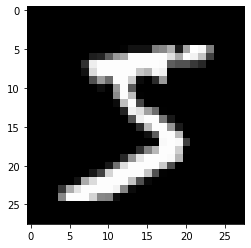

In [12]:
plt.imshow(img[0], cmap = 'gray')

In [13]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [14]:
batch_size=128

In [15]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


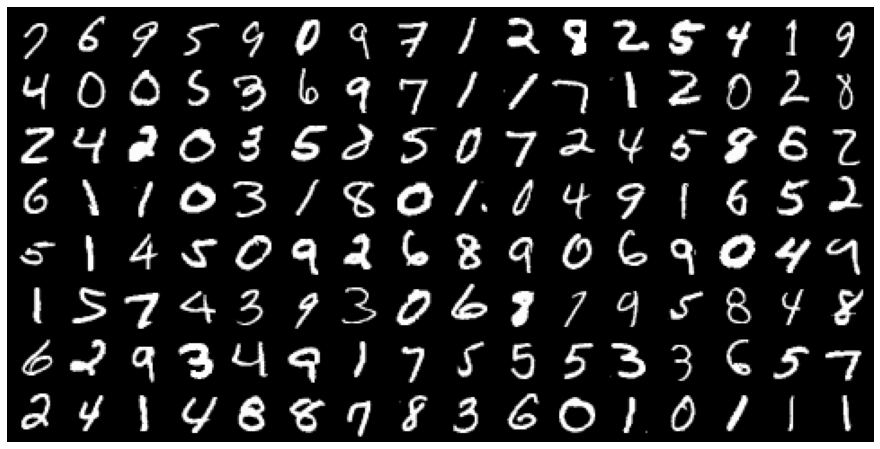

In [16]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [19]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [20]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [21]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [22]:
for images, labels in train_loader:
    #print('images.shape', images.shape)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.30273175239563
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0524,  0.0315,  0.1131,  0.0662,  0.1418, -0.0230,  0.0365,  0.1449,
         -0.0553,  0.0096],
        [-0.0006, -0.0764,  0.0770, -0.0914,  0.0960,  0.0578, -0.0410,  0.0734,
          0.0055,  0.1374]])


In [23]:
jovian.commit(project ='CNN-GPU')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/arbaza/CNN-GPU


<IPython.core.display.Javascript object>

In [24]:
torch.cuda.is_available()

False

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [26]:
device = get_default_device()
device

device(type='cpu')

In [27]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [28]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [29]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [31]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([2, 1, 7, 6, 8, 2, 2, 6, 1, 2, 5, 7, 2, 4, 3, 9, 5, 2, 4, 8, 0, 2, 5, 4,
        0, 4, 5, 8, 9, 9, 7, 5, 6, 8, 3, 4, 9, 9, 7, 5, 6, 0, 7, 9, 7, 8, 4, 4,
        9, 8, 9, 5, 5, 2, 2, 6, 8, 5, 0, 0, 1, 0, 6, 3, 3, 8, 2, 2, 7, 2, 8, 7,
        4, 2, 3, 4, 8, 9, 8, 8, 8, 5, 2, 7, 1, 5, 8, 1, 1, 4, 8, 4, 2, 6, 6, 5,
        4, 5, 9, 7, 1, 5, 7, 3, 0, 6, 3, 7, 1, 4, 4, 3, 3, 2, 1, 7, 5, 2, 8, 2,
        9, 3, 2, 6, 7, 8, 7, 7, 1, 3, 6, 3, 2, 1, 1, 1, 9, 0, 3, 0, 0, 9, 5, 1,
        1, 1, 8, 7, 1, 1, 5, 9, 2, 9, 9, 0, 1, 3, 3, 4, 0, 2, 7, 2, 8, 3, 4, 5,
        9, 2, 4, 6, 9, 3, 6, 0, 4, 8, 7, 1, 7, 3, 6, 0, 3, 6, 9, 7, 2, 2, 9, 4,
        2, 8, 6, 0, 6, 3, 9, 7, 7, 8, 1, 5, 1, 9, 0, 0, 3, 3, 8, 8, 5, 1, 4, 7,
        3, 2, 2, 1, 1, 4, 6, 4, 0, 6, 9, 5, 8, 9, 6, 7, 3, 6, 8, 9, 4, 7, 9, 1,
        2, 1, 2, 6, 3, 4, 9, 2, 8, 1, 4, 0, 7, 7, 6, 1])


In [32]:
#Training the Model
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [33]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [34]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3029284477233887, 'val_acc': 0.08749999850988388}]

In [35]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3113, val_acc: 0.9014
Epoch [1], val_loss: 0.1635, val_acc: 0.9506
Epoch [2], val_loss: 0.1520, val_acc: 0.9547
Epoch [3], val_loss: 0.1295, val_acc: 0.9608
Epoch [4], val_loss: 0.1378, val_acc: 0.9585


In [36]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1097, val_acc: 0.9674
Epoch [1], val_loss: 0.1091, val_acc: 0.9681
Epoch [2], val_loss: 0.1093, val_acc: 0.9683
Epoch [3], val_loss: 0.1079, val_acc: 0.9683
Epoch [4], val_loss: 0.1057, val_acc: 0.9693


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

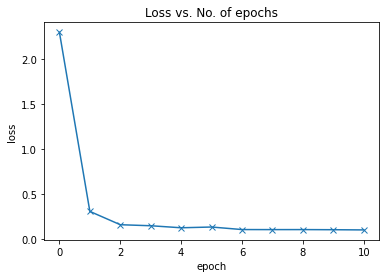

In [38]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

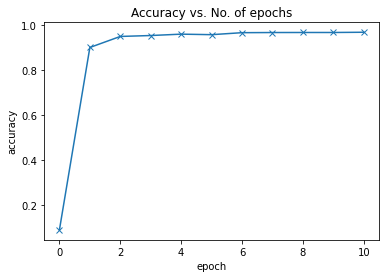

In [39]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [40]:
#pip install jovian


Note: you may need to restart the kernel to use updated packages.


In [41]:
jovian.commit(project = 'CNN-GPU')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/arbaza/CNN-GPU


<IPython.core.display.Javascript object>